# Моделирование винеровского процесса

Будем моделировать винеровский процесс, используя тот факт, что процесс
$$X_t = \frac{\xi_0 t}{\sqrt{\pi}} + \sqrt{\frac{2}{\pi}}\sum_{k = 1}^{\infty}\frac{\sin{kt}}{k}\xi_k$$
является винеровским на отрезке $[0, \pi]$, где $\xi_i$ -- независимые распределенные по закону $Norm(0, 1)$ случайные величины.

Рассмотрим
$$X_t^{(n)} = \frac{\xi_0 t}{\sqrt{\pi}} + \sqrt{\frac{2}{\pi}}\sum_{k = 1}^{n}\frac{\sin{kt}}{k}\xi_k$$.
В курсе случайных процессов доказано, что при достаточно больших $n$ этот процесс будет хорошо приближать $X_t$. Рассмотрим реализацию:

In [58]:
%matplotlib inline
from scipy.stats import norm
import matplotlib.pyplot as plot
import math
import numpy

class WienerProcess:
    const = math.sqrt(2 / math.pi)
    def __init__(self, n):
        self.n = n
        self.samples = norm.rvs(loc = 0, scale = 1, size = n)
    
    def valueAt(self, x):
        s = sum(map(lambda k: self.const * math.sin(k*x)*self.samples[k]/k, range(1, self.n)))
        return s + self.samples[0]*x/math.sqrt(math.pi)
    
    def __getitem__(self, times):
        return list(map(lambda x: self.valueAt(x), times))

## Масштабная инвариантность винеровского процесса

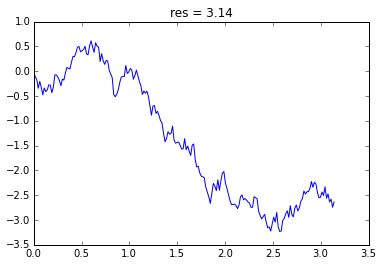

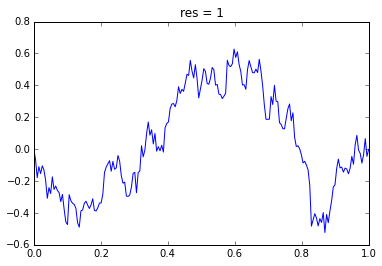

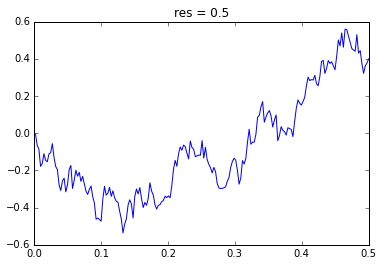

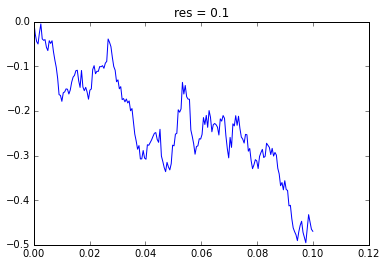

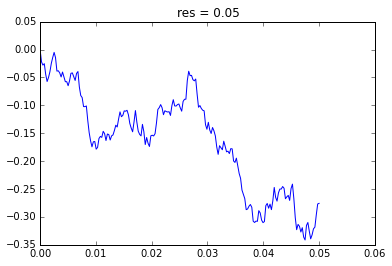

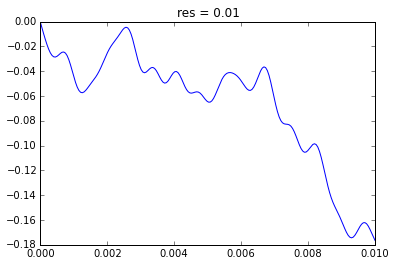

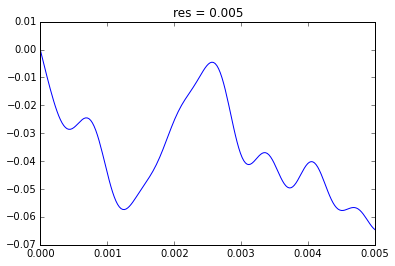

In [59]:
x = WienerProcess(10000)
for res in [3.14, 1, 0.5, 0.1, 0.05, 0.01, 0.005]:
    xs = numpy.linspace(0, res, 200)
    plot.figure()
    plot.title('res = ' + str(res))
    ys = x[xs]
    plot.plot(xs, ys)
    plot.show()

Видно, что при слишком большом масштабе $X_t^{(n)}$ выраждается в линейную комбинацию синусов. Это происходит из-за того, что большинство синусов в сумме в окрестности нуля равны нулю и только синусы с очень большими частотами (то есть при большом n) не обнуляются. Понятно, что $X_t^{(n)}$ диффиринцируема в любой точке $t$ при любом $\omega$, т.к. это конечная линейная комбинация синусов, в отличие от $X_t$.

## Графики при различных n

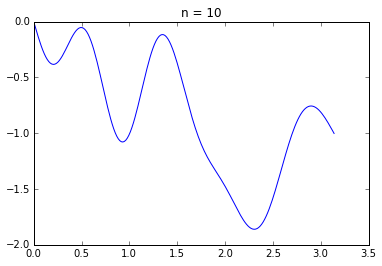

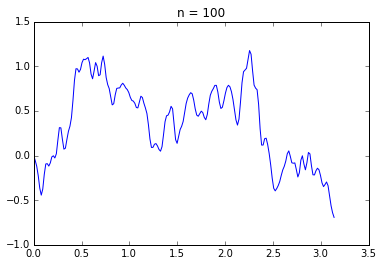

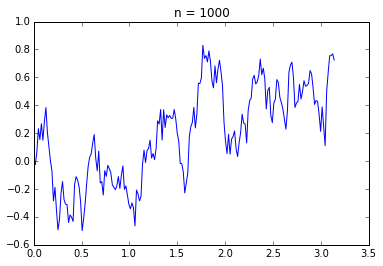

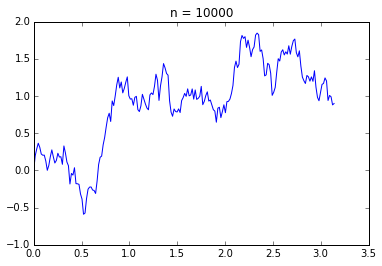

In [60]:
xs = numpy.linspace(0, 3.14, 200)
for n in [10, 100, 1000, 10000]:
    x = WienerProcess(n)
    ys = x[xs]
    plot.figure()
    plot.title('n = ' + str(n))
    plot.plot(xs, ys)
    plot.show()

# Модель Миллера-Орра

investing
selling shares
investing
taking loan
apocalypse
paying loan
apocalypse
apocalypse
apocalypse
taking loan
investing
investing
investing
investing
investing
investing
investing
paying loan
selling shares
investing
selling shares
apocalypse
apocalypse
taking loan
apocalypse
taking loan
paying loan
paying loan
investing
selling shares
investing
taking loan


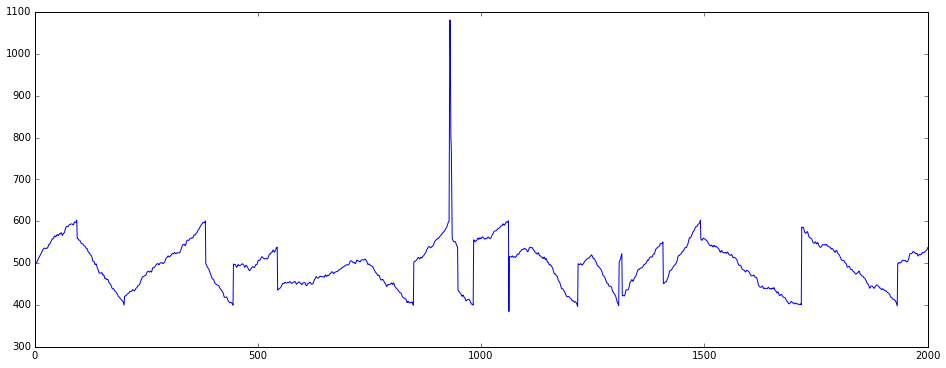

In [105]:
from scipy.stats import laplace
from scipy.stats import expon

money_start = 500
money_min = 400
money_max = 600
money_optimal = 500
loan_new_b = 1
loan_new_dev = 0.5
loan_time = 100
shares_new_b = 1
shares_new_b_dev = 0.5
shares_new_a_dev = 50
invest_new_a_dev = 100
invest_new_b_dev = 0.5
invest_new_b = -1
k = 50

noise = WienerProcess(1000)
step = 1
max_time = 2000

current_b = 1
current_time = 0
current_money = money_start
current_loans = []

def take_loan():
    print("taking loan")
    global current_money, current_b, current_loans
    loan_amount = money_optimal - current_money
    current_money = money_optimal
    current_b = norm.rvs(loc = loan_new_b, scale = loan_new_dev)
    current_loans.append((current_time + loan_time, loan_amount))

def sell_shares():
    print("selling shares")
    global current_money, current_b
    current_money = current_money + norm.rvs(loc = money_optimal - money_min, scale = shares_new_a_dev)
    current_b = norm.rvs(loc = shares_new_b, scale = shares_new_b_dev)

def invest():
    print("investing")
    global current_money, current_b
    current_money = current_money + laplace.rvs(loc = (money_optimal - money_max) / 2, scale = invest_new_a_dev)
    current_b = norm.rvs(loc = invest_new_b, scale = invest_new_b_dev)

times = []
moneys = []

risks_intensity = 0.003
next_risk_time = expon.rvs(scale = 1 / risks_intensity)
risk_new_b_dev = 1
    
while(current_time <= max_time):
    if (current_time >= next_risk_time):
        print("apocalypse")
        next_risk_time = next_risk_time + expon.rvs(scale = 1 / risks_intensity)
        current_b = norm.rvs(scale = risk_new_b_dev)
        
    new_loans = []
    for (lease_time, lease_amount) in current_loans:
        if (current_time >= lease_time):
            print("paying loan")
            current_money = current_money - lease_amount
        else:
            new_loans.append((lease_time, lease_amount))
    current_loans = new_loans
    current_money = current_money + current_b * step + k * (noise.valueAt(math.pi*(current_time/max_time)) - noise.valueAt(math.pi*((current_time - step)/max_time))) 
    times.append(current_time)
    moneys.append(current_money)
    if (current_money <= money_min):
        if (norm.rvs() > 0):
            sell_shares()
        else:
            take_loan()
    if (current_money >= money_max):
        invest()
    current_time += step
    
plot.figure(figsize=(16, 6))
plot.plot(times, moneys)
plot.show()